## DreamBooth on Stable Diffusion 2.1

DreamBooth is a powerful technique for personalizing latent diffusion models, such as Stable Diffusion, allowing the model to be fine-tuned to generate specific images based on a limited set of data.

### Step 0: Environment configuration

This command installs the "diffusers" library directly from the Hugging Face GitHub repository.The diffusers library is used to work with latent diffusion models, such as Stable Diffusion, and provides tools for image generation, fine-tuning, and other functionalities.


In [5]:
!pip install -r ../requirements.txt --quiet

### Configuration and Secrets Loading
In this section, we load configuration parameters and API keys from separate YAML files. This separation helps maintain security by keeping sensitive information (API keys) separate from configuration settings.

- **config.yaml**: Contains non-sensitive configuration parameters like model sources and URLs
- **secrets.yaml**: Contains sensitive API keys for services like Galileo and HuggingFace


In [6]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from src.utils import load_config_and_secrets

from core.custom_metrics.image_metrics_scorers import entropy_scorer, complexity_scorer, set_custom_image_path
from core.deploy.deploy_image_generation import deploy_model
from core.local_inference.inference import StableDiffusionPipelineOutput, load_config, run_inference
from core.dreambooth_inference.inference_dreambooth import StableDiffusionPipelineOutput, load_config_dreambooth, run_inference_dreambooth



from huggingface_hub import snapshot_download
import promptquality as pq
import glob

In [7]:
config_path = "../../configs/config.yaml"
secrets_path = "../../configs/secrets.yaml"

config, secrets = load_config_and_secrets(config_path, secrets_path)

### Download model local

This code imports the snapshot_download function from the huggingface_hub library to download the latest version of the "stabilityai/stable-diffusion-2-1" model. It sets a local directory for saving the model (local_model_path), and the download is configured to be resumable in case it is interrupted, with an etag timeout set to 60 seconds.

In [4]:
# Download the snapshot directly to the local directory
local_model_path = os.path.join("..", "..", "..", "local", "stable-diffusion-2-1")

# Downloading the latest revision of the "stabilityai/stable-diffusion-2-1" model
snapshot_download(
    repo_id="stabilityai/stable-diffusion-2-1", 
    local_dir=local_model_path,
    resume_download=True,
    etag_timeout=60  
)

/opt/conda/lib/python3.12/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Fetching 28 files:   0%|          | 0/28 [00:00<?, ?it/s]

model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/12.2k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/681M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

pytorch_model.fp16.bin:   0%|          | 0.00/681M [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

(…)5a7d2fd41238de486cd797d2f70fbe45e1a1c310:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/939 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.bin:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

(…)ea81afce2b5bb7d1983c6b94793a26a3b54b08a0:   0%|          | 0.00/5.21G [00:00<?, ?B/s]

v2-1_768-ema-pruned.safetensors:   0%|          | 0.00/5.21G [00:00<?, ?B/s]

v2-1_768-nonema-pruned.ckpt:   0%|          | 0.00/5.21G [00:00<?, ?B/s]

v2-1_768-nonema-pruned.safetensors:   0%|          | 0.00/5.21G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

'/home/jovyan/local/stable-diffusion-2-1'

### Step 1: Load the Model
We load the pre-trained Stable Diffusion 2.1 model from Hugging Face and move it to the GPU for efficient execution

Detected 2 GPUs, using config/default_config_multi-gpu.yaml
GPU 0: 45GB of available memory.
GPU 1: 45GB of available memory.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/opt/conda/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Taking `'Attention' object has no attribute 'key'` while using `accelerate.load_checkpoint_and_dispatch` to mean ../../../local/stable-diffusion-2-1/vae was saved with deprecated attention block weight names. We will load it with the deprecated attention block names and convert them on the fly to the new attention block format. Please re-save the model after this conversion, so we don't have to do the on the fly renaming in the future. If the model is from a hub checkpoint, please also re-upload it or open a PR on the original repository.


  0%|          | 0/60 [00:00<?, ?it/s]

Average Inference Time: 15.87 seconds
Median Inference Time: 15.87 seconds
Min Inference Time: 15.87 seconds
Max Inference Time: 15.87 seconds


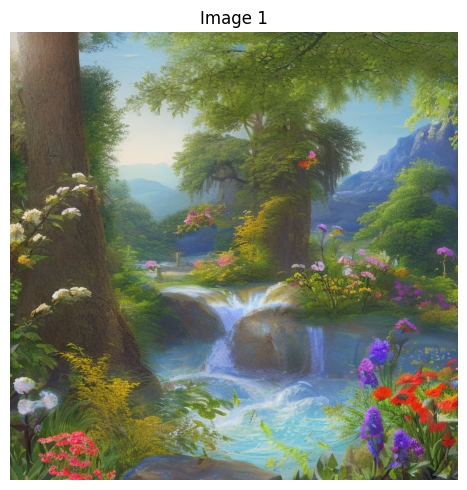

In [5]:
config = load_config()

run_inference(
    prompt="A beautiful landscape",
    height=768,
    width=768,
    num_images=1,
    num_inference_steps=60,
    output=True  
)



## Step 3: Training Dreambooth

This Bash script checks the available GPUs using PyTorch, selects a multi-GPU or single-GPU configuration file accordingly, and then launches a training script (using accelerate) for Dreambooth on Stable Diffusion with specified parameters. It also records and calculates the training duration.

In [6]:
%%bash
NUM_GPUS=$(python3 -c "import torch; print(torch.cuda.device_count())")

if [ "$NUM_GPUS" -ge 2 ]; then
  CONFIG_FILE="config/default_config_multi-gpu.yaml"
  echo "Detected $NUM_GPUS GPUs, using $CONFIG_FILE"
else
  CONFIG_FILE="config/default_config_one-gpu.yaml"
  echo "Detected $NUM_GPUS GPU, using $CONFIG_FILE"
fi

START=$(date +%s)

accelerate launch --config_file $CONFIG_FILE core/train/train_dreambooth_aistudio.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-2-1"  \
  --instance_data_dir="../data/img" \
  --output_dir="./dreambooth/" \
  --instance_prompt="A modern laptop on a sandy beach with the ocean in the background, sunlight reflecting off the screen" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --learning_rate=5e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=400 \
  --logging_dir="/phoenix/tensorboard/tensorlogs" \
  --report_to="tensorboard" \
  --validation_prompt="A photo of an HP laptop on the sand with a sunset over the ocean in the background." \
  --num_validation_images=1 \
  --validation_steps=100

END=$(date +%s)
DIFF=$(( $END - $START ))


Detected 2 GPUs, using config/default_config_multi-gpu.yaml
[2025-04-29 13:42:20,750] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


df: /home/jovyan/.triton/autotune: No such file or directory
W0429 13:42:33.271000 838 site-packages/torch/distributed/run.py:792] 
W0429 13:42:33.271000 838 site-packages/torch/distributed/run.py:792] *****************************************
W0429 13:42:33.271000 838 site-packages/torch/distributed/run.py:792] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0429 13:42:33.271000 838 site-packages/torch/distributed/run.py:792] *****************************************
2025-04-29 13:42:39.498140: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-29 13:42:39.498150: I tensorflow/core/util/port.cc:153] oneDNN

[2025-04-29 13:42:54,780] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
[2025-04-29 13:42:54,896] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
[2025-04-29 13:42:56,029] [INFO] [comm.py:652:init_distributed] cdb=None
[2025-04-29 13:42:56,029] [INFO] [comm.py:683:init_distributed] Initializing TorchBackend in DeepSpeed with backend nccl
[2025-04-29 13:42:56,150] [INFO] [comm.py:652:init_distributed] cdb=None


04/29/2025 13:42:56 - INFO - __main__ - Distributed environment: DistributedType.DEEPSPEED  Backend: nccl
Num processes: 2
Process index: 0
Local process index: 0
Device: cuda:0

Mixed precision type: no
ds_config: {'train_batch_size': 'auto', 'train_micro_batch_size_per_gpu': 'auto', 'gradient_accumulation_steps': 1, 'zero_optimization': {'stage': 2, 'offload_optimizer': {'device': 'none', 'nvme_path': None}, 'offload_param': {'device': 'none', 'nvme_path': None}, 'stage3_gather_16bit_weights_on_model_save': False}, 'gradient_clipping': 1.0, 'steps_per_print': inf, 'fp16': {'enabled': False}, 'bf16': {'enabled': False}}

/opt/conda/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31

[2025-04-29 13:44:22,602] [INFO] [config.py:733:__init__] Config mesh_device None world_size = 2
[2025-04-29 13:44:22,602] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed info: version=0.15.1, git-hash=unknown, git-branch=unknown
[2025-04-29 13:44:22,602] [INFO] [config.py:733:__init__] Config mesh_device None world_size = 2
[2025-04-29 13:44:28,983] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed Flops Profiler Enabled: False
[2025-04-29 13:44:28,990] [INFO] [logging.py:96:log_dist] [Rank 0] Using client Optimizer as basic optimizer
[2025-04-29 13:44:28,990] [INFO] [logging.py:96:log_dist] [Rank 0] Removing param_group that has no 'params' in the basic Optimizer
[2025-04-29 13:44:29,074] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed Basic Optimizer = AdamW
[2025-04-29 13:44:29,074] [INFO] [utils.py:59:is_zero_supported_optimizer] Checking ZeRO support for optimizer=AdamW type=<class 'torch.optim.adamw.AdamW'>
[2025-04-29 13:44:29,074] [INFO] [logging.py:96:log_dist] [Rank 0

04/29/2025 13:44:58 - INFO - __main__ - ***** Running training *****
04/29/2025 13:44:58 - INFO - __main__ -   Num examples = 4
04/29/2025 13:44:58 - INFO - __main__ -   Num batches each epoch = 2
04/29/2025 13:44:58 - INFO - __main__ -   Num Epochs = 200
04/29/2025 13:44:58 - INFO - __main__ -   Instantaneous batch size per device = 1
04/29/2025 13:44:58 - INFO - __main__ -   Total train batch size (w. parallel, distributed & accumulation) = 2
04/29/2025 13:44:58 - INFO - __main__ -   Gradient Accumulation steps = 1
04/29/2025 13:44:58 - INFO - __main__ -   Total optimization steps = 400
04/29/2025 13:44:58 - INFO - __main__ - Checking validation condition: step 0, validation every 100 steps
Steps:  25%|██▌       | 100/400 [03:21<09:49,  1.97s/it, loss=0.201, lr=5e-6]04/29/2025 13:48:20 - INFO - __main__ - Running validation at step 100.
04/29/2025 13:48:20 - INFO - __main__ - Starting validation process.
04/29/2025 13:48:20 - INFO - __main__ - Generating 1 images with prompt: A photo

## Inference Local Model

This code imports functions from the inference_dreambooth module, loads a configuration, and then runs inference to generate images. It uses a prompt to create three images with a resolution of 768x768 pixels, executing 100 inference steps per image.

Detected 2 GPUs, using config/default_config_multi-gpu.yaml
GPU 0: 45GB of available memory.
GPU 1: 45GB of available memory.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Average Inference Time: 15.67 seconds
Median Inference Time: 13.43 seconds
Min Inference Time: 13.25 seconds
Max Inference Time: 20.32 seconds


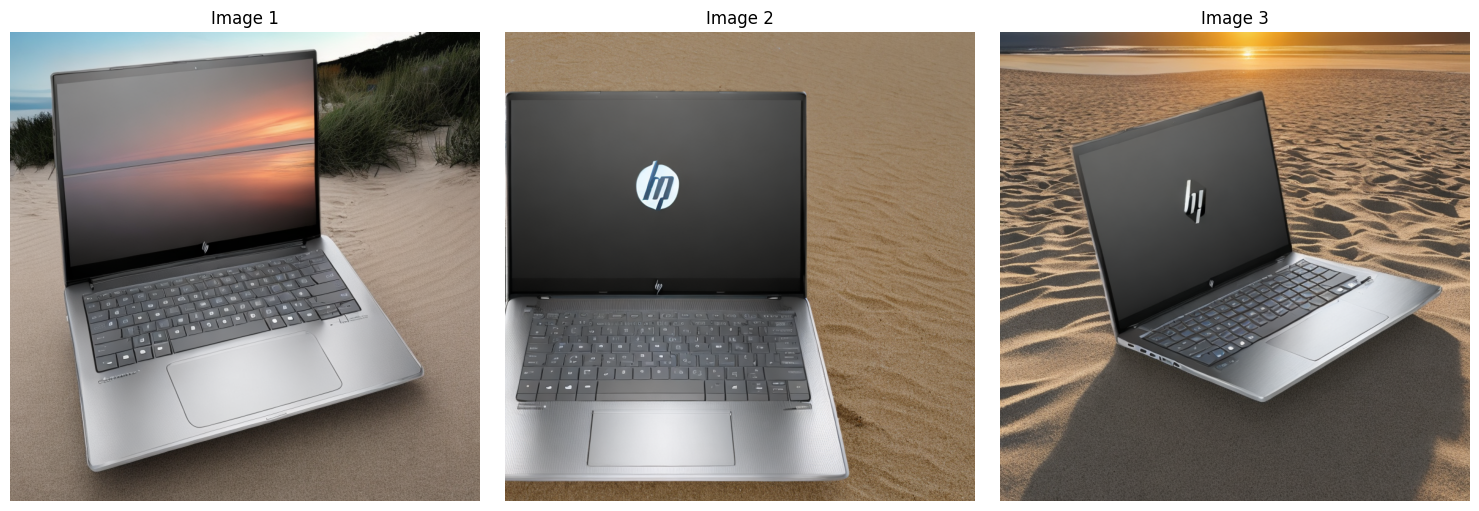

In [7]:
config = load_config_dreambooth()

run_inference_dreambooth(
    prompt="A high-quality photo of an HP laptop placed on the sand at the beach, with a sunset over the ocean in the background.", 
    height=768, 
    width=768, 
    num_images=3, 
    num_inference_steps=100,
    output=True
)


## Galileo Evaluate Custom metrics
Galileo GenAI Studio supports Custom Metrics (programmatic or GPT-based) for all your Evaluate and Observe projects. 

In [3]:
"""
# If the kernel goes into idle state, log in with your credentials again.
"""

import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from src.utils import load_config_and_secrets


In [8]:

#########################################
# In order to connect to Galileo, create a secrets.yaml file in the same folder as this notebook
# This file should be an entry called Galileo, with the your personal Galileo API Key
# Galileo API keys can be created on https://console.hp.galileocloud.io/settings/api-keys
#########################################

os.environ['GALILEO_API_KEY'] = secrets["GALILEO_API_KEY"]
os.environ['GALILEO_CONSOLE_URL'] = "https://console.hp.galileocloud.io/"
pq.login(os.environ['GALILEO_CONSOLE_URL'])

👋 You have logged into 🔭 Galileo (https://console.hp.galileocloud.io/) as diogo.vieira@hp.com.


Config(console_url=HttpUrl('https://console.hp.galileocloud.io/'), username=None, password=None, api_key=SecretStr('**********'), token=SecretStr('**********'), current_user='diogo.vieira@hp.com', current_project_id=None, current_project_name=None, current_run_id=None, current_run_name=None, current_run_url=None, current_run_task_type=None, current_template_id=None, current_template_name=None, current_template_version_id=None, current_template_version=None, current_template=None, current_dataset_id=None, current_job_id=None, current_prompt_optimization_job_id=None, api_url=HttpUrl('https://api.hp.galileocloud.io/'))

In [9]:

#########################################

# Returns the path of the most recent image that matches the specified pattern.

#########################################

def get_latest_generated_image(directory: str = "./", prefix: str = "local_model_result_", ext: str = ".png") -> str:
    files = glob.glob(os.path.join(directory, f"{prefix}*{ext}"))
    if not files:
        raise FileNotFoundError("No generated images found.")
    latest_file = max(files, key=os.path.getmtime)
    return latest_file

Detected 2 GPUs, using config/default_config_multi-gpu.yaml
GPU 0: 45GB of available memory.
GPU 1: 45GB of available memory.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Average Inference Time: 24.17 seconds
Median Inference Time: 24.17 seconds
Min Inference Time: 24.17 seconds
Max Inference Time: 24.17 seconds


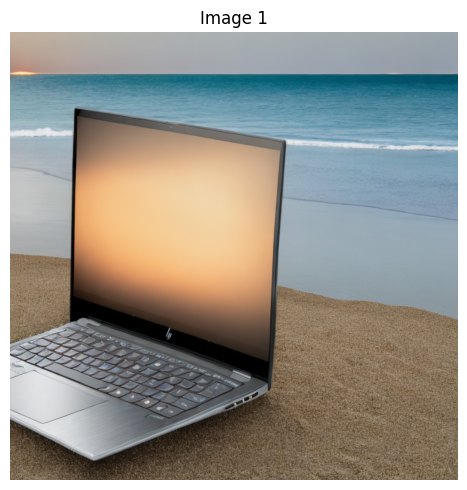

[set_custom_image_path] CUSTOM_IMAGE_PATH atualizado para: ./local_model_result_0.png


Processing LLM output...:   0%|          | 0/8 [00:00<?, ?it/s]

Initial job complete, executing scorers asynchronously. Current status:
cost: Done ✅
toxicity: Done ✅
pii: Done ✅
protect_status: Done ✅
latency: Done ✅
🔭 View your prompt run on the Galileo console at: https://console.hp.galileocloud.io/prompt/4ee56e00-c05b-4226-9881-27fe0bcb5eb3/da811ce9-bf79-4d04-9206-9ffb1e52f701?taskType=7
[executor_entropy] Using image_path: ./local_model_result_0.png
[load_image] Loading the image of: ./local_model_result_0.png
[load_image] Image loaded with shape: (768, 768, 3), dtype: float32
[convert_to_grayscale] Image converted to grayscale. Shape: (768, 768)
[shannon_entropy_np] Entropia calculada: -148.2268927998821
[executor_entropy] Entropy: -148.2268927998821


In [ ]:

config = load_config_dreambooth()

prompt_text = ("A high-quality photo of an HP laptop placed on the sand at the beach, "
               "with a sunset over the ocean in the background.")

run_inference_dreambooth(
    prompt=prompt_text, 
    height=768, 
    width=768, 
    num_images=1, 
    num_inference_steps=100,
    output=True
)

generated_image_path = get_latest_generated_image()

set_custom_image_path(generated_image_path)

template = prompt_text

result_custom = pq.run(template=template, scorers=[entropy_scorer, complexity_scorer])
print("Result:", result_custom)

## Model Service

Using MLflow, we will save and load the model in an integrated manner, enabling the traceability and reproducibility of experiments. MLflow will facilitate model versioning, monitoring, and deployment, ensuring a robust pipeline for your project.

In [12]:
deploy_model()

2025-04-29 14:12:17,520 - INFO - Using multi-GPU configuration with 2 GPUs.
2025/04/29 14:12:17 INFO mlflow.tracking.fluent: Experiment with name 'ImageGeneration' does not exist. Creating a new experiment.
2025-04-29 14:12:19,338 - INFO - Run started: da5b2f8fffea4be9add6c71b5a1c141a
2025-04-29 14:12:19,521 - INFO - Accelerate configuration file logged in.
2025-04-29 14:12:19,523 - INFO - Starting model logging...


2025-04-29 14:31:57,084 - INFO - Model successfully logged into MLflow.
2025-04-29 14:31:57,086 - INFO - Model successfully logged in.
Successfully registered model 'ImageGenerationService'.
Created version '1' of model 'ImageGenerationService'.
2025-04-29 14:31:57,451 - INFO - Registered model: ImageGenerationService
